In [1]:
# BASIC IMPORTS
import sys
sys.path.append(r'..\src')

import pandas as pd

import pylab as plt

import seaborn as sns

import numpy as np

import re

import mysql.connector as conn

from ufc_fights import set_names_upper, set_name_winner, fix_columns, set_nan_columns
from ufc_fighters import set_fighter_upper, clean_fighters, load_ufc_fighters, load_ufc_fighters_styles

In [2]:
# MACHINE LEARNING IMPORTS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor as RFR
rfr=RFR()

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

import h2o
from h2o.automl import H2OAutoML

In [3]:
fighter = pd.read_csv(r'..\data\raw_fighter_details.csv')

data = pd.read_csv(r'..\data\data.csv')

ufc_fighters = pd.read_csv(r'..\data\ufc_fighters_official.csv')

ufc_styles = pd.read_csv(r'..\data\ufc_fighters_styles.csv')

# TABLA LUCHADORES

In [ ]:
# load_ufc_fighters() scrapea luchadores UFC por categoría de peso
# load_ufc_fighters_styles() scrapea luchadores UFC por estilo
# dejo comentado porque ya está scrapeado y tengo los datos

#load_ufc_fighters()
#load_ufc_fighters_styles()

In [4]:
# Join entre luchadores recopilados y estilos recopilados
ufc_styles = ufc_styles.drop_duplicates('Name')

x = ufc_fighters.set_index('Nombres').join(ufc_styles[['Name','Category','Record','Style']].set_index('Name'),
                                               rsuffix='_dcha', how='left')

x.insert(0, 'Nombres', x.index)
x.reset_index(drop=True, inplace=True)
x = x.drop(['Category', 'Record_dcha', 'Unnamed: 0'], axis=1)
x = x.drop_duplicates('Nombres')
x.reset_index(drop=True, inplace=True)

In [5]:
set_fighter_upper(fighter)

fighters = clean_fighters(fighter, x)

fighters

,fighter_id,Name,Style,MMA_Style,DOB,Wins,Losses,Draws,Categoría,Height_cm,...,Reach_cm,Stance,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg
0,0,PAPY ABEDI,MMA,SWITCH,1978-06-30 00:00:00,9,3,0,Middleweight,180.34,...,182.88,Southpaw,2.80,0.55,3.15,0.48,3.47,0.57,0.50,1.3
1,1,SHAMIL ABDURAKHIMOV,Grappler,GRAPPLING,1981-09-02 00:00:00,20,7,0,Heavyweight,190.50,...,193.04,Orthodox,2.45,0.44,2.45,0.58,1.23,0.24,0.47,0.2
2,2,DANNY ABBADI,MMA,SWITCH,1983-07-03 00:00:00,2,2,0,Lightweight,180.34,...,182.88,Orthodox,3.29,0.38,4.41,0.57,0.00,0.00,0.77,0.0
3,3,RICARDO ABREU,MMA,SWITCH,1984-04-27 00:00:00,5,1,0,Middleweight,180.34,...,182.88,Orthodox,3.79,0.31,3.98,0.68,2.13,0.42,1.00,0.7
4,4,DAICHI ABE,MMA,SWITCH,1991-11-27 00:00:00,6,1,0,Welterweight,180.34,...,180.34,Orthodox,3.80,0.33,4.49,0.56,0.33,0.50,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2203,2203,ZHALGAS ZHUMAGULOV,Freestyle,GRAPPLING,1988-08-29 00:00:00,14,6,0,Flyweight,162.56,...,167.64,Switch,4.17,0.49,4.00,0.58,1.50,0.21,0.33,0.0
2204,2204,JAMES ZIKIC,MMA,SWITCH,1977-03-01 00:00:00,16,3,0,Light Heavyweight,187.96,...,182.88,Orthodox,1.47,0.35,1.60,0.44,0.50,0.25,0.74,0.5
2205,2205,CAT ZINGANO,MMA,SWITCH,1982-07-01 00:00:00,10,4,0,Women's Featherweight,167.64,...,172.72,Southpaw,2.57,0.61,1.63,0.47,2.77,0.65,0.42,0.8
2206,2206,IGOR ZINOVIEV,MMA,SWITCH,0,0,0,0,Middleweight,185.42,...,182.88,Orthodox,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0


# TABLA FIGHTS

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6012 entries, 0 to 6011
Columns: 144 entries, R_fighter to R_age
dtypes: bool(1), float64(106), int64(28), object(9)
memory usage: 6.6+ MB


In [7]:
data.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,...,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Adrian Yanez,Gustavo Lopez,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Bantamweight,0.000,0.0,...,0,1,0,0,Orthodox,170.18,177.80,135.0,31.0,27.0
1,Trevin Giles,Roman Dolidze,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Middleweight,0.500,0.0,...,0,3,0,0,Orthodox,182.88,187.96,185.0,32.0,28.0
2,Tai Tuivasa,Harry Hunsucker,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Heavyweight,NaN,NaN,...,1,3,0,0,Southpaw,187.96,190.50,264.0,32.0,28.0
3,Cheyanne Buys,Montserrat Conejo,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenStrawweight,NaN,NaN,...,0,0,0,0,Switch,160.02,160.02,115.0,28.0,25.0
4,Marion Reneau,Macy Chiasson,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenBantamweight,0.125,0.0,...,1,2,2,0,Orthodox,167.64,172.72,135.0,29.0,43.0


In [8]:
set_names_upper(data)

fix_columns(data)

set_nan_columns(data)

data

,fight_id,R_fighter,B_fighter,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_SIG_STR_pct,...,B_PCT_BODY,R_PCT_BODY,B_PCT_LEG,R_PCT_LEG,B_PCT_DISTANCE,R_PCT_DISTANCE,B_PCT_CLINCH,R_PCT_CLINCH,B_PCT_GROUND,R_PCT_GROUND
0,0,ADRIAN YANEZ,GUSTAVO LOPEZ,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Bantamweight,0.000000,0.420000,...,93.0,100.0,67.0,83.0,36.0,48.0,43.0,100.0,67.0,70.0
1,1,TREVIN GILES,ROMAN DOLIDZE,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Middleweight,0.500000,0.660000,...,67.0,71.0,93.0,100.0,52.0,52.0,100.0,52.0,64.0,74.0
2,2,TAI TUIVASA,HARRY HUNSUCKER,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Heavyweight,0.015625,0.450000,...,71.0,79.0,83.0,83.0,37.0,44.0,68.0,76.0,70.0,75.0
3,3,CHEYANNE BUYS,MONTSERRAT CONEJO,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenStrawweight,0.015625,0.450000,...,71.0,70.0,83.0,83.0,37.0,37.0,68.0,68.0,70.0,70.0
4,4,MARION RENEAU,MACY CHIASSON,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenBantamweight,0.125000,0.535625,...,84.0,78.0,60.0,86.0,33.0,33.0,74.0,74.0,50.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6007,6007,REMCO PARDOEL,ALBERTA CERRA LEON,1994-03-11,"Denver, Colorado, USA",Red,False,OpenWeight,0.015625,0.450000,...,71.0,70.0,83.0,83.0,37.0,37.0,68.0,68.0,70.0,70.0
6008,6008,ORLANDO WIET,ROBERT LUCARELLI,1994-03-11,"Denver, Colorado, USA",Red,False,OpenWeight,0.015625,0.450000,...,71.0,70.0,83.0,83.0,37.0,37.0,68.0,68.0,70.0,70.0
6009,6009,JOHNNY RHODES,DAVID LEVICKI,1994-03-11,"Denver, Colorado, USA",Red,False,OpenWeight,0.015625,0.450000,...,71.0,70.0,83.0,83.0,37.0,37.0,68.0,68.0,70.0,70.0
6010,6010,PATRICK SMITH,RAY WIZARD,1994-03-11,"Denver, Colorado, USA",Red,False,OpenWeight,0.015625,0.450000,...,71.0,70.0,83.0,83.0,37.0,37.0,68.0,68.0,70.0,70.0


## LOAD DATABASE

In [9]:
'''data1 = data.copy()

set_name_winner(data1)

data1.insert(4, 'City', '')
data1.insert(5, 'State', '')
data1.insert(6, 'Country', '')
data1.location = data1.location.str.split(',')

data1.City = data1.location.str[0]
data1.State[data1.location.str.len()==3] = data1.location.str[1]
data1.Country[data1.location.str.len()==3] = data1.location.str[2]
data1.Country[data1.location.str.len()==2] = data1.location.str[1]
data1.State[data1.State==''] = data1.City
data1 = data1.drop('location', axis=1)
data1'''

"data1 = data.copy()\n\nset_name_winner(data1)\n\ndata1.insert(4, 'City', '')\ndata1.insert(5, 'State', '')\ndata1.insert(6, 'Country', '')\ndata1.location = data1.location.str.split(',')\n\ndata1.City = data1.location.str[0]\ndata1.State[data1.location.str.len()==3] = data1.location.str[1]\ndata1.Country[data1.location.str.len()==3] = data1.location.str[2]\ndata1.Country[data1.location.str.len()==2] = data1.location.str[1]\ndata1.State[data1.State==''] = data1.City\ndata1 = data1.drop('location', axis=1)\ndata1"

In [10]:
'''crea_db=conn.connect(host='localhost', user='root', passwd='10081973')

cursor=crea_db.cursor()

cursor.execute('drop database if exists ufc_predictions_db;')
cursor.execute('create database ufc_predictions_db;')
cursor.execute('use ufc_predictions_db;')'''

"crea_db=conn.connect(host='localhost', user='root', passwd='10081973')\n\ncursor=crea_db.cursor()\n\ncursor.execute('drop database if exists ufc_predictions_db;')\ncursor.execute('create database ufc_predictions_db;')\ncursor.execute('use ufc_predictions_db;')"

cursor.execute('drop table if exists fighters;')

tabla='''
        create table fighters (
            
            fighter_id int, Name varchar(100) primary key, Style varchar(100), MMA_Style varchar(100), DOB datetime,
            Wins int, Losses int, Draws int, Categoría varchar(100), Height_cm float, Weight_kg float, Reach_cm float,
            Stance varchar(100), SLpM float, Str_Acc float, SApM float, Str_Def float, TD_Avg float,
            TD_Acc float, TD_Def float, Sub_Avg float);
'''

cursor.execute(tabla)

In [11]:
'''for i in range(len(fighters)):
    
    insert_query='insert into {} ({}) values {};'\
                 .format('fighters', ','.join(fighters.columns), tuple(fighters.iloc[i].values))
    
    insert_query=f"insert into fighters ({','.join(fighters.columns)}) values {tuple(fighters.iloc[i].values)};"
    
    cursor.execute(insert_query)
    
crea_db.commit()'''

'for i in range(len(fighters)):\n    \n    insert_query=\'insert into {} ({}) values {};\'                 .format(\'fighters\', \',\'.join(fighters.columns), tuple(fighters.iloc[i].values))\n    \n    insert_query=f"insert into fighters ({\',\'.join(fighters.columns)}) values {tuple(fighters.iloc[i].values)};"\n    \n    cursor.execute(insert_query)\n    \ncrea_db.commit()'

cursor.execute('drop table if exists fights;')

tabla='''

        create table fights (
            
            fight_id int, R_fighter varchar(100), B_fighter varchar(100), date datetime, City varchar(100),
            State varchar(100), Country varchar(100), Winner varchar(100), title_bout bool, weight_class varchar(100),
            
            B_avg_KD float, B_avg_SIG_STR_pct float,
            B_avg_TD_pct float, B_avg_SUB_ATT float, B_avg_REV float, B_avg_TD_att float, B_avg_TD_landed float,
            B_avg_CTRL_time float, B_total_time_fought float, B_total_rounds_fought int, B_total_title_bouts int,
            B_wins int, B_losses int, B_win_by_Decision_Majority int, B_win_by_Decision_Split int,
            B_win_by_Decision_Unanimous int, B_win_by_KO int, B_win_by_Submission int,
            B_win_by_TKO_Doctor_Stoppage int, B_Stance varchar(100), B_Height_cms float, B_Reach_cms float,
            B_Weight_lbs float, 
            
            R_avg_KD float, R_avg_SIG_STR_pct float, R_avg_TD_pct float, R_avg_SUB_ATT float, R_avg_REV float,
            R_avg_TD_att float, R_avg_TD_landed float, R_avg_CTRL_time float, R_total_time_fought float,
            R_total_rounds_fought int, R_total_title_bouts int, R_wins int, R_losses int, R_win_by_Decision_Majority int,
            R_win_by_Decision_Split int, R_win_by_Decision_Unanimous int, R_win_by_KO int, R_win_by_Submission int,
            R_win_by_TKO_Doctor_Stoppage int, R_Stance varchar(100), R_Height_cms float, R_Reach_cms float,
            R_Weight_lbs float,
            
            B_age int, R_age int, B_PCT_STRIKES float, R_PCT_STRIKES float, B_PCT_HEAD float, R_PCT_HEAD float,
            B_PCT_BODY float, R_PCT_BODY float, B_PCT_LEG float, R_PCT_LEG float, B_PCT_DISTANCE float,
            R_PCT_DISTANCE float, B_PCT_CLINCH float, R_PCT_CLINCH float, B_PCT_GROUND float, R_PCT_GROUND float
        );
'''

cursor.execute(tabla)

In [12]:
'''for i in range(len(data1)):
    
    insert_query='insert into {} ({}) values {};'\
                 .format('fights', ','.join(data1.columns), tuple(data1.iloc[i].values))
    
    insert_query=f"insert into fights ({','.join(data1.columns)}) values {tuple(data1.iloc[i].values)};"
    
    cursor.execute(insert_query)
    
crea_db.commit()'''

'for i in range(len(data1)):\n    \n    insert_query=\'insert into {} ({}) values {};\'                 .format(\'fights\', \',\'.join(data1.columns), tuple(data1.iloc[i].values))\n    \n    insert_query=f"insert into fights ({\',\'.join(data1.columns)}) values {tuple(data1.iloc[i].values)};"\n    \n    cursor.execute(insert_query)\n    \ncrea_db.commit()'

## MAKING PREDICTIONS

In [13]:
# Las reglas oficiales de la UFC no entraron hasta el año 2001, así que solo cogemos combates por encima del año 2002
data = data[data.date>'2002-01-01']
# Eliminamos DRAW en Winner para ir probando
data = data[data.Winner!='Draw']
# Eliminamos la columna LOCATION
data = data.drop('location', axis=1)
# Borramos el id al ser innecesario
data = data.drop('fight_id', axis=1)

In [14]:
plt.figure(figsize=(50, 40))

corr_matrix = data.iloc[:,:].corr(method = 'pearson').abs()

sns.heatmap(corr_matrix, annot=True)

"plt.figure(figsize=(50, 40))\n\ncorr_matrix = data.iloc[:,:].corr(method = 'pearson').abs()\n\nsns.heatmap(corr_matrix, annot=True)"

In [16]:
# FUNCTION FOR SELECT THE LAST OR FIRST FIGHT OF A CONCRETE FIGHTER

#  i = index of the fighter's fight, 0 means the last fight, -1 means first fight
def select_fight_row(df, name, i): 
    
    df_temp = df[(df['R_fighter'] == name) | (df['B_fighter'] == name)]  # filter df on fighter's name
    
    df_temp.reset_index(drop=True, inplace=True) #  as we created a new temporary dataframe, we have to reset indexes
    
    idx = max(df_temp.index)  #  get the index of the oldest fight
    
    if i > idx:  #  if we are looking for a fight that didn't exist, we return nothing
        
        return
    
    arr = df_temp.iloc[i].values
    
    return arr

select_fight_row(data, 'GLOVER TEIXEIRA', 0) #  we get the last fight of Jon Jones, for example

array(['THIAGO SANTOS', 'GLOVER TEIXEIRA',
       Timestamp('2020-11-07 00:00:00'), 'Blue', False,
       'LightHeavyweight', 0.5010185241699219, 0.5823753356933594,
       0.3318797302246093, 0.7385482788085938, 0.5001220703125,
       3.757099151611328, 0.8489723205566406, 323.5913734436035,
       979.0288124084472, 46, 1, 14, 5, 0, 1, 2, 5, 5, 1, 'Orthodox',
       187.96, 193.04, 205.0, 0.5208015441894531, 0.3907491683959961,
       0.367393798828125, 0.03125, 0.0703125, 0.916156768798828,
       0.53228759765625, 38.99400329589844, 1044.601333618164, 37, 1, 13,
       6, 0, 0, 2, 11, 0, 0, 'Orthodox', 187.96, 193.04, 205.0, 41.0,
       36.0, 68.0, 39.0, 57.0, 24.0, 72.0, 49.0, 100.0, 58.0, 48.0, 32.0,
       67.0, 62.0, 81.0, 56.0], dtype=object)

In [17]:
# GET ALL ACTIVE FIGHTERS ACCORDING TO THE LIMIT DATE

def list_fighters(df):
    
    set_R, set_B = set(df['R_fighter']), set(df['B_fighter'])
    
    return list(set_R.union(set_B))

fighters = list_fighters(data)

len(fighters)

1952

In [18]:
# FUNCTION FOR BUILD A DATAFRAME WHICH HAS LAST/FIRST/... FIGHTS OF SELECTED FIGHTERS

def build_df(df, fighters, i):
    
    arr = [select_fight_row(df, fighters[f], i) for f in range(len(fighters)) if select_fight_row(df, fighters[f], i) is not None]
    
    cols = [col for col in df] 
    
    df_fights = pd.DataFrame(data=arr, columns=cols)
    
    df_fights.drop_duplicates(inplace=True)
    
    df_fights['title_bout'] = df_fights['title_bout'].replace({True: 1, False: 0})
    
    df_fights.drop(['R_fighter', 'B_fighter', 'date'], axis=1, inplace=True)
    
    return df_fights

df_train = build_df(data, fighters, 0)
df_test = build_df(data, fighters, 1)

In [19]:
df_train.shape, df_test.shape

((1694, 65), (1490, 65))

In [20]:
# AMOUNT OF WINNERS RED OR BLUE IN TRAIN AND TEST DATAFRAMES

print(len(df_train[df_train['Winner'] == 'Blue']))
print(len(df_train[df_train['Winner'] == 'Red']))

print(len(df_test[df_test['Winner'] == 'Blue']))
print(len(df_test[df_test['Winner'] == 'Red']))

602
1092
520
970


In [21]:
# TRANSFORM DATA FOR LabelEncoder TO OBJECT COLUMNS

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import make_column_transformer

preprocessor = make_column_transformer((OrdinalEncoder(), ['weight_class', 'B_Stance', 'R_Stance']),
                                       remainder='passthrough')

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(df_train['Winner'])
y_test = label_encoder.transform(df_test['Winner'])

X_train, X_test = df_train.drop(['Winner'], axis=1), df_test.drop(['Winner'], axis=1)

In [22]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(1694, 64)
(1694,)
(1490, 64)
(1490,)


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

random_forest = RandomForestClassifier(n_estimators=100, 
                                       criterion='entropy',   
                                       random_state=42)

model = Pipeline([('encoding', preprocessor), ('random_forest', random_forest)])
model.fit(X_train, y_train)

# We use cross-validation with 5-folds to have a more precise accuracy (reduce variation)
accuracies = cross_val_score(estimator=model, X=X_train, y=y_train)
print('Accuracy mean : ', np.nanmean(accuracies))
print('Accuracy standard deviation : ', np.nanstd(accuracies))

y_pred = model.predict(X_test)
print('Testing accuracy : ', accuracy_score(y_test, y_pred), '\n')

target_names = ["Blue","Red"]
print(classification_report(y_test, y_pred, labels=[0,1], target_names=target_names))

Accuracy mean :  0.6745562130177515
Accuracy standard deviation :  0.014134612467296137
Testing accuracy :  0.7328859060402685 

              precision    recall  f1-score   support

        Blue       0.70      0.41      0.52       520
         Red       0.74      0.90      0.82       970

    accuracy                           0.73      1490
   macro avg       0.72      0.66      0.67      1490
weighted avg       0.73      0.73      0.71      1490



[Text(0, 0.5, 'Blue'), Text(0, 1.5, 'Red')]

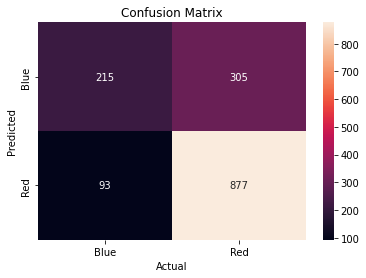

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred) 
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, fmt = "d")

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Confusion Matrix")

ax.xaxis.set_ticklabels(['Blue', 'Red'])
ax.yaxis.set_ticklabels(['Blue', 'Red'])

In [43]:
'''feature_names = [col for col in X_train]
feature_importances = model['random_forest'].feature_importances_
indices = np.argsort(feature_importances)[::-1]
n = 30 # maximum feature importances displayed
idx = indices[0:n] 
std = np.std([tree.feature_importances_ for tree in model['random_forest'].estimators_], axis=0)

#for f in range(n):
#    print("%d. feature %s (%f)" % (f + 1, feature_names[idx[f]], feature_importances[idx[f]])) 

plt.figure(figsize=(30, 8))
plt.title("Feature importances")
plt.bar(range(n), feature_importances[idx], color="r", yerr=std[idx], align="center")
plt.xticks(range(n), [feature_names[id] for id in idx], rotation = 45) 
plt.xlim([-1, n]) 
plt.show()'''

'feature_names = [col for col in X_train]\nfeature_importances = model[\'random_forest\'].feature_importances_\nindices = np.argsort(feature_importances)[::-1]\nn = 30 # maximum feature importances displayed\nidx = indices[0:n] \nstd = np.std([tree.feature_importances_ for tree in model[\'random_forest\'].estimators_], axis=0)\n\n#for f in range(n):\n#    print("%d. feature %s (%f)" % (f + 1, feature_names[idx[f]], feature_importances[idx[f]])) \n\nplt.figure(figsize=(30, 8))\nplt.title("Feature importances")\nplt.bar(range(n), feature_importances[idx], color="r", yerr=std[idx], align="center")\nplt.xticks(range(n), [feature_names[id] for id in idx], rotation = 45) \nplt.xlim([-1, n]) \nplt.show()'

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5623 entries, 0 to 5725
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   R_fighter                     5623 non-null   object        
 1   B_fighter                     5623 non-null   object        
 2   date                          5623 non-null   datetime64[ns]
 3   Winner                        5623 non-null   object        
 4   title_bout                    5623 non-null   bool          
 5   weight_class                  5623 non-null   object        
 6   B_avg_KD                      5623 non-null   float64       
 7   B_avg_SIG_STR_pct             5623 non-null   float64       
 8   B_avg_TD_pct                  5623 non-null   float64       
 9   B_avg_SUB_ATT                 5623 non-null   float64       
 10  B_avg_REV                     5623 non-null   float64       
 11  B_avg_TD_att                  

In [26]:
def predict(df, pipeline, blue_fighter, red_fighter, weightclass, rounds, title_bout=False): 
    
    #We build two dataframes, one for each figther 
    f1 = df[(df['R_fighter'] == blue_fighter) | (df['B_fighter'] == blue_fighter)].copy()
    f1.reset_index(drop=True, inplace=True)
    f1 = f1[:1]
    f2 = df[(df['R_fighter'] == red_fighter) | (df['B_fighter'] == red_fighter)].copy()
    f2.reset_index(drop=True, inplace=True)
    f2 = f2[:1]
    
    # if the fighter was red/blue corner on his last fight, we filter columns to only keep his statistics (and not the other fighter)
    # then we rename columns according to the color of  the corner in the parameters using re.sub()
    if (f1.loc[0, ['R_fighter']].values[0]) == blue_fighter:
        result1 = f1.filter(regex='^R', axis=1).copy() #here we keep the red corner stats
        result1.rename(columns = lambda x: re.sub('^R','B', x), inplace=True)  #we rename it with "B_" prefix because he's in the blue_corner
    else: 
        result1 = f1.filter(regex='^B', axis=1).copy()
    if (f2.loc[0, ['R_fighter']].values[0]) == red_fighter:
        result2 = f2.filter(regex='^R', axis=1).copy()
    else:
        result2 = f2.filter(regex='^B', axis=1).copy()
        result2.rename(columns = lambda x: re.sub('^B','R', x), inplace=True)
        
    fight = pd.concat([result1, result2], axis = 1) # we concatenate the red and blue fighter dataframes (in columns)
    fight.drop(['R_fighter','B_fighter'], axis = 1, inplace = True) # we remove fighter names
    fight.insert(0, 'title_bout', title_bout) # we add tittle_bout, weight class and number of rounds data to the dataframe
    fight.insert(1, 'weight_class', weightclass)
    fight.insert(2, 'no_of_rounds', rounds)
    fight['title_bout'] = fight['title_bout'].replace({True: 1, False: 0})
    
    pred = pipeline.predict(fight)
    proba = pipeline.predict_proba(fight)
    if (pred == 1.0): 
        print("The predicted winner is", red_fighter, 'with a probability of', round(proba[0][1] * 100, 2), "%")
    else:
        print("The predicted winner is", blue_fighter, 'with a probability of ', round(proba[0][0] * 100, 2), "%")
    return proba

In [27]:
predict(data, model, 'JIRI PROCHAZKA', 'GLOVER TEIXEIRA', 'LightHeavyweight', 5, True) 

In [28]:
predict(data, model, 'GLOVER TEIXEIRA', 'JIRI PROCHAZKA', 'LightHeavyweight', 5, True) 

In [29]:
predict(data, model, 'VALENTINA SHEVCHENKO', 'TAILA SANTOS', 'WomenFlyweight', 5, True)

The predicted winner is TAILA SANTOS with a probability of 69.0 %


array([[0.31, 0.69]])

In [30]:
predict(data, model, 'TAILA SANTOS', 'VALENTINA SHEVCHENKO', 'WomenFlyweight', 5, True) 

The predicted winner is VALENTINA SHEVCHENKO with a probability of 54.0 %


array([[0.46, 0.54]])

In [31]:
predict(data, model, 'ALEXANDER VOLKANOVSKI', 'MAX HOLLOWAY', 'Featherweight', 5, True) 

The predicted winner is MAX HOLLOWAY with a probability of 56.0 %


array([[0.44, 0.56]])

In [32]:
predict(data, model, 'MAX HOLLOWAY', 'ALEXANDER VOLKANOVSKI', 'Featherweight', 5, True) 

The predicted winner is ALEXANDER VOLKANOVSKI with a probability of 79.0 %


array([[0.21, 0.79]])

### LOGISTIC REGRESSION AND RANDOM FOREST

In [33]:
'''# label encoding 

le=LabelEncoder()

for c in data.columns:
    
    if data.dtypes[c]==object:
        
        le.fit(data[c].astype(str))
        
        data[c]=le.transform(data[c].astype(str))

X = data.drop('Winner', axis=1)

y = data.Winner

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, train_size=0.8,
                                                    random_state=42)

logreg=LogisticRegression(max_iter=2000)

# RMSE POR MODELO
models = [logreg, rfr]

for m in models:
    
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    
    print(f'RMSE Model {m}: {mse(y_test, y_pred, squared=False)}')
    print(f'R2 Model {m}: {r2(y_test, y_pred)}')
    
sum(y_pred==y_test)/y_pred.shape[0]*100'''

"# label encoding \n\nle=LabelEncoder()\n\nfor c in data.columns:\n    \n    if data.dtypes[c]==object:\n        \n        le.fit(data[c].astype(str))\n        \n        data[c]=le.transform(data[c].astype(str))\n\nX = data.drop('Winner', axis=1)\n\ny = data.Winner\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, \n                                                    test_size=0.2, train_size=0.8,\n                                                    random_state=42)\n\nlogreg=LogisticRegression(max_iter=2000)\n\n# RMSE POR MODELO\nmodels = [logreg, rfr]\n\nfor m in models:\n    \n    m.fit(X_train, y_train)\n    y_pred = m.predict(X_test)\n    \n    print(f'RMSE Model {m}: {mse(y_test, y_pred, squared=False)}')\n    print(f'R2 Model {m}: {r2(y_test, y_pred)}')\n    \nsum(y_pred==y_test)/y_pred.shape[0]*100"

### H2O

In [34]:
'''train = data.iloc[:4580]

test = data.iloc[4580:].drop('Winner', axis=1)

train.shape, test.shape'''

"train = data.iloc[:4580]\n\ntest = data.iloc[4580:].drop('Winner', axis=1)\n\ntrain.shape, test.shape"

In [35]:
'''# H2O

h2o.init()

# parsear datos para h20

h2train=h2o.H2OFrame(train)

h2test=h2o.H2OFrame(test)

X=[c for c in h2train.columns if c!='Winner']

y='Winner'

# inicia auto-machine-learning

automl=H2OAutoML(max_models=50,
                 seed=42,
                 max_runtime_secs=300,
                 sort_metric='RMSE')'''

"# H2O\n\nh2o.init()\n\n# parsear datos para h20\n\nh2train=h2o.H2OFrame(train)\n\nh2test=h2o.H2OFrame(test)\n\nX=[c for c in h2train.columns if c!='Winner']\n\ny='Winner'\n\n# inicia auto-machine-learning\n\nautoml=H2OAutoML(max_models=50,\n                 seed=42,\n                 max_runtime_secs=300,\n                 sort_metric='RMSE')"

In [36]:
'''# entrena

automl.train(x=X,
             y=y,
             training_frame=h2train)'''

'# entrena\n\nautoml.train(x=X,\n             y=y,\n             training_frame=h2train)'

In [37]:
'''# prediciones del lider

y_pred = automl.leader.predict(h2test)

y_pred = y_pred.as_data_frame()

y_pred'''

'# prediciones del lider\n\ny_pred = automl.leader.predict(h2test)\n\ny_pred = y_pred.as_data_frame()\n\ny_pred'